# Union de archivo de velocidades del plan maestro de movilidad

Se agregan las velocidades del plan maestro de movilidad para aumentar los datos

## Necesarios
* Base de datos de velocidades en excel
* Base de datos de velocidades
* Librerias necesarias instaladas

In [1]:
# Tratamiento de datos
# ==============================================================================
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gpd
import math as mt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se carga el archivo de excel que contienelas celdas tener en cuenta de hacer coinsidir el nombre
#de las columnas que mas se puedan para asi hacer un mejor uso de los datos
archcarro = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/carro.xlsx'
archmoto = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/Moto.xlsx'
archTPC = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/TPC.xlsx'

dfcar = pd.read_excel(archcarro, sheet_name='Hoja1')
dfmot = pd.read_excel(archmoto, sheet_name='Hoja1')
dfTPC = pd.read_excel(archTPC, sheet_name='Hoja1')

print(dfcar.head(2))
print(dfmot.head(2))
print(dfTPC.head(2))

  file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0   EO   3    1010     2.22222     8.00000 2017-06-20 06:38:43  4.45837   
1   EO   4     966     3.88889    14.00000 2017-06-20 06:38:58  4.45807   

   longitud      fecha        t0    tiempo  
0 -75.12582 2017-06-20  06:00:00  06:38:43  
1 -75.12577 2017-06-20  06:00:00  06:38:58  
  file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0   EO  27     911     1.66667     6.00000 2017-06-22 07:45:05  4.45717   
1   EO  28     910     3.61111    13.00000 2017-06-22 07:45:07  4.45717   

   longitud      fecha        t0    tiempo  
0 -75.12560 2017-06-22  07:00:00  07:45:05  
1 -75.12563 2017-06-22  07:00:00  07:45:07  
   file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0     1   1    1324     5.55556    20.00000 2017-06-16 09:11:55  4.45272   
1     1   2    1325     5.00000    18.00000 2017-06-16 09:12:02  4.45293   

   longitud    tiempo  
0 -75.24493  09:11:55  
1

In [3]:
#Se llaman los datos de velocidad obtenidos en el GPX
velcar = gpd.read_file("C:/Users/user/Desktop/Tesis/PuntosVelocidades/p_vel_orig/Carro.shp")
velmot = gpd.read_file("C:/Users/user/Desktop/Tesis/PuntosVelocidades/p_vel_orig/Moto.shp")
velTPC = gpd.read_file("C:/Users/user/Desktop/Tesis/PuntosVelocidades/p_vel_orig/TPC.shp")

print(velcar.head(2))
print(velmot.head(2))
print(velTPC.head(2))

   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.43089 -75.24018 1217.72900  11-09-2020  12:25:01   
1   2  4.43089 -75.24017 1217.56100  11-09-2020  12:25:02   

             timestamp                            file        t0         A0  \
0  2020-09-11 12:25:01  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   
1  2020-09-11 12:25:02  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   

   velocity_m  velocity_k     slope                       geometry  
0     0.00000     0.00000   0.00000  POINT (870947.965 981821.229)  
1     0.20794     0.74860 -80.79070  POINT (870947.887 981821.168)  
   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.40523 -75.16315 1029.02100  09-09-2020  17:09:58   
1   2  4.40523 -75.16315 1029.05400  09-09-2020  17:09:59   

             timestamp                           file        t0         A0  \
0  2020-09-09 17:09:58  2020-09-09_12-09_Wed moto.gpx  17:09:58 1029.02100   
1  2020-09-09 17:09:59  2020-09

## Carro

In [4]:
#Para obterner el geometry de estas velocidades en excel se localizan segun las coordenadas
gdfTPC = gpd.GeoDataFrame(
    dfTPC, geometry=gpd.points_from_xy(dfTPC.longitud, dfTPC.latitud),crs={"init":"EPSG:4326"})

In [5]:
#Se convierte el formato a magna sirgas bogota
gdfTPC = gdfTPC.to_crs({"init":"EPSG:3116"})

In [6]:
#Se visualizan los datos para entender mejor
gdfTPC.head(2)

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,geometry
0,1,1,1324,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,POINT (870423.510 984235.894)
1,1,2,1325,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,POINT (870392.095 984259.908)


<AxesSubplot:>

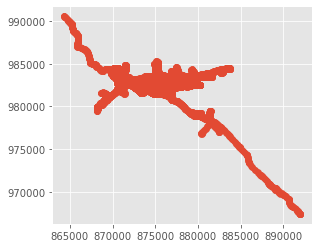

In [7]:
#Se grafican para visualizar que los datos sean coherentes con la malla vial
gdfTPC.plot()

In [8]:
#Se crea la columna de angulos
gdfTPC['angulo_vel']=0.0

In [9]:
#se toman los atributos para calcular el azimut
for i in range(0, len(gdfTPC)-1):
    if  (gdfTPC["file"].iloc[i] == gdfTPC["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=gdfTPC.loc[i,'geometry'].x
        y1=gdfTPC.loc[i,'geometry'].y
        x2=gdfTPC.loc[i+1,'geometry'].x
        y2=gdfTPC.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=gdfTPC.iloc[i-1,-1]                
    gdfTPC.loc[i,'angulo_vel']=ang
gdfTPC.loc[i+1,'angulo_vel']=ang
gdfTPC

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,geometry,angulo_vel
0,1,1,1324,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,POINT (870423.510 984235.894),307.39506
1,1,2,1325,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,POINT (870392.095 984259.908),201.45898
2,1,3,1331,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,POINT (870349.370 984151.215),192.94028
3,1,4,1333,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,POINT (870340.055 984110.675),126.86010
4,1,5,1333,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,POINT (870354.838 984099.591),119.16920
...,...,...,...,...,...,...,...,...,...,...,...
13605,82,388,1396,2.22222,8.00000,2017-06-16 08:44:20,4.41492,-75.26335,08:44:20,POINT (868372.403 980058.305),230.39011
13606,82,389,1398,5.55556,20.00000,2017-06-16 08:44:27,4.41483,-75.26345,08:44:27,POINT (868361.287 980049.106),239.80475
13607,82,390,1402,7.50000,27.00000,2017-06-16 08:44:38,4.41455,-75.26393,08:44:38,POINT (868307.580 980017.853),238.42684
13608,82,391,1407,5.83333,21.00000,2017-06-16 08:44:50,4.41412,-75.26463,08:44:50,POINT (868229.793 979970.049),220.00145


In [10]:
#Se crea la columna de angulos
velTPC['angulo_vel']=0.0

In [11]:
#se toman los atributos para calcular el azimut
for i in range(0, len(velTPC)-1):
    if  (velTPC["file"].iloc[i] == velTPC["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=velTPC.loc[i,'geometry'].x
        y1=velTPC.loc[i,'geometry'].y
        x2=velTPC.loc[i+1,'geometry'].x
        y2=velTPC.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=velTPC.iloc[i-1,-1]                
    velTPC.loc[i,'angulo_vel']=ang
velTPC.loc[i+1,'angulo_vel']=ang
velTPC

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,angulo_vel
0,1,4.44176,-75.16338,1095.00000,02-10-2015,11:30:52,2015-10-02 11:30:52,15 2015-10-02_09-00_vie - Julieth.gpx,11:30:52,1095.00000,0.00000,0.00000,0.00000,POINT (879474.209 983001.376),220.47051
1,2,4.44039,-75.16441,1029.00000,02-10-2015,11:40:45,2015-10-02 11:40:45,15 2015-10-02_09-00_vie - Julieth.gpx,11:30:52,1095.00000,0.32045,1.15361,-34.73237,POINT (879417.492 982934.900),218.44714
2,3,4.44038,-75.16448,1030.00000,02-10-2015,11:40:47,2015-10-02 11:40:47,15 2015-10-02_09-00_vie - Julieth.gpx,11:40:45,1029.00000,3.80509,13.69831,13.14030,POINT (879356.575 982858.172),257.53179
3,4,4.44036,-75.16453,1031.00000,02-10-2015,11:40:49,2015-10-02 11:40:49,15 2015-10-02_09-00_vie - Julieth.gpx,11:40:47,1030.00000,3.26948,11.77013,15.29295,POINT (879349.668 982856.644),254.39747
4,5,4.44034,-75.16462,1034.00000,02-10-2015,11:40:52,2015-10-02 11:40:52,15 2015-10-02_09-00_vie - Julieth.gpx,11:40:49,1031.00000,3.25643,11.72313,30.70852,POINT (879341.828 982854.455),250.13253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46005,46025,4.44378,-75.17069,1040.00000,14-08-2015,14:19:30,2015-08-14 14:19:30,_ 2015-08-14_08-59_vie - Julieth.gpx,14:19:27,1041.00000,1.59447,5.74010,-20.90558,POINT (878660.911 983233.991),74.59437
46006,46026,4.44379,-75.17065,1040.00000,14-08-2015,14:19:32,2015-08-14 14:19:32,_ 2015-08-14_08-59_vie - Julieth.gpx,14:19:30,1040.00000,2.61968,9.43086,0.00000,POINT (878665.742 983235.322),75.00027
46007,46027,4.44381,-75.17057,1039.00000,14-08-2015,14:19:35,2015-08-14 14:19:35,_ 2015-08-14_08-59_vie - Julieth.gpx,14:19:32,1040.00000,2.82994,10.18779,-11.77881,POINT (878672.372 983237.098),76.43489
46008,46028,4.44382,-75.17054,1038.00000,14-08-2015,14:19:37,2015-08-14 14:19:37,_ 2015-08-14_08-59_vie - Julieth.gpx,14:19:35,1039.00000,1.68487,6.06554,-29.67585,POINT (878678.135 983238.489),74.85601


In [12]:
#Se cambia el formato de la hora y fecha
gdfTPC["tiempo"] = gdfTPC["tiempo"].apply(
    lambda row: 
    row.strftime("%H:%M:%S")
    )
gdfTPC["timestamp"] = gdfTPC["timestamp"].apply(
    lambda row: 
    row.strftime("%Y-%m-%d %H:%M:%S")
    )
gdfTPC

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,geometry,angulo_vel
0,1,1,1324,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,POINT (870423.510 984235.894),307.39506
1,1,2,1325,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,POINT (870392.095 984259.908),201.45898
2,1,3,1331,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,POINT (870349.370 984151.215),192.94028
3,1,4,1333,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,POINT (870340.055 984110.675),126.86010
4,1,5,1333,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,POINT (870354.838 984099.591),119.16920
...,...,...,...,...,...,...,...,...,...,...,...
13605,82,388,1396,2.22222,8.00000,2017-06-16 08:44:20,4.41492,-75.26335,08:44:20,POINT (868372.403 980058.305),230.39011
13606,82,389,1398,5.55556,20.00000,2017-06-16 08:44:27,4.41483,-75.26345,08:44:27,POINT (868361.287 980049.106),239.80475
13607,82,390,1402,7.50000,27.00000,2017-06-16 08:44:38,4.41455,-75.26393,08:44:38,POINT (868307.580 980017.853),238.42684
13608,82,391,1407,5.83333,21.00000,2017-06-16 08:44:50,4.41412,-75.26463,08:44:50,POINT (868229.793 979970.049),220.00145


In [17]:
#Se concatenan los datos en un nuevo dataframe para luego ser guardados
TPC = pd.concat([gdfTPC, velTPC], axis = 0)
TPC

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,geometry,angulo_vel,fecha,t0,A0,slope
0,1,1,1324.00000,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,POINT (870423.510 984235.894),307.39506,NaN,NaN,NaN,NaN
1,1,2,1325.00000,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,POINT (870392.095 984259.908),201.45898,NaN,NaN,NaN,NaN
2,1,3,1331.00000,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,POINT (870349.370 984151.215),192.94028,NaN,NaN,NaN,NaN
3,1,4,1333.00000,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,POINT (870340.055 984110.675),126.86010,NaN,NaN,NaN,NaN
4,1,5,1333.00000,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,POINT (870354.838 984099.591),119.16920,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46005,_ 2015-08-14_08-59_vie - Julieth.gpx,46025,1040.00000,1.59447,5.74010,2015-08-14 14:19:30,4.44378,-75.17069,14:19:30,POINT (878660.911 983233.991),74.59437,14-08-2015,14:19:27,1041.00000,-20.90558
46006,_ 2015-08-14_08-59_vie - Julieth.gpx,46026,1040.00000,2.61968,9.43086,2015-08-14 14:19:32,4.44379,-75.17065,14:19:32,POINT (878665.742 983235.322),75.00027,14-08-2015,14:19:30,1040.00000,0.00000
46007,_ 2015-08-14_08-59_vie - Julieth.gpx,46027,1039.00000,2.82994,10.18779,2015-08-14 14:19:35,4.44381,-75.17057,14:19:35,POINT (878672.372 983237.098),76.43489,14-08-2015,14:19:32,1040.00000,-11.77881
46008,_ 2015-08-14_08-59_vie - Julieth.gpx,46028,1038.00000,1.68487,6.06554,2015-08-14 14:19:37,4.44382,-75.17054,14:19:37,POINT (878678.135 983238.489),74.85601,14-08-2015,14:19:35,1039.00000,-29.67585


In [18]:
#Se eliminan las columnas que puedan tener datos NaN
TPC = TPC.drop(['A0', 'slope', 'fecha', 't0'], axis=1)
TPC

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,geometry,angulo_vel
0,1,1,1324.00000,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,POINT (870423.510 984235.894),307.39506
1,1,2,1325.00000,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,POINT (870392.095 984259.908),201.45898
2,1,3,1331.00000,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,POINT (870349.370 984151.215),192.94028
3,1,4,1333.00000,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,POINT (870340.055 984110.675),126.86010
4,1,5,1333.00000,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,POINT (870354.838 984099.591),119.16920
...,...,...,...,...,...,...,...,...,...,...,...
46005,_ 2015-08-14_08-59_vie - Julieth.gpx,46025,1040.00000,1.59447,5.74010,2015-08-14 14:19:30,4.44378,-75.17069,14:19:30,POINT (878660.911 983233.991),74.59437
46006,_ 2015-08-14_08-59_vie - Julieth.gpx,46026,1040.00000,2.61968,9.43086,2015-08-14 14:19:32,4.44379,-75.17065,14:19:32,POINT (878665.742 983235.322),75.00027
46007,_ 2015-08-14_08-59_vie - Julieth.gpx,46027,1039.00000,2.82994,10.18779,2015-08-14 14:19:35,4.44381,-75.17057,14:19:35,POINT (878672.372 983237.098),76.43489
46008,_ 2015-08-14_08-59_vie - Julieth.gpx,46028,1038.00000,1.68487,6.06554,2015-08-14 14:19:37,4.44382,-75.17054,14:19:37,POINT (878678.135 983238.489),74.85601


In [19]:
#Se guarda el archivo en la ruta deseada
TPC.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/shapes/TPC.shp")

Se continua en el codigo alojado en Outlayer-velocidades_PMMEP